## Skin Cancer Classification Transfer Learning DenseNet121

In [3]:
import os
import shutil
# from tqdm import tqdm

import cv2
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("classic")

### Train Test Split

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(preprocessing_function=base_preprocess,
                               rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               #rescale=1/255,
                               validation_split=0.20)

2024-10-15 15:15:59.775369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 15:15:59.791720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 15:15:59.796711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 15:15:59.808315: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 15:16:00.606742: W tensorflow/compiler/tf2

In [5]:
data_dir = './HAM_Dataset'
batch_size = 64
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7528218..1.666715].


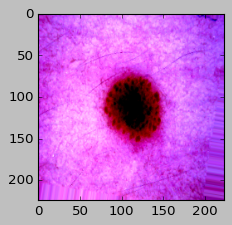

In [6]:
plt.figure(figsize=(3,3))
plt.imshow(train_image_gen[0][0][0])

## Transfer Learning using DenseNet121 Model

In [7]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

I0000 00:00:1729005363.693760     596 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729005363.716230     596 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729005363.716296     596 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729005363.718505     596 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729005363.718606     596 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 13,461,063 (51.35 MB)

 Trainable params: 13,377,415 (51.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('densenet.keras',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

### Model Training

In [10]:
import tensorflow as tf

# Check if GPUs are available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")

    # Limit GPU memory usage to 12 GB
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # 12 GB in MB
        )
        print("Successfully set GPU memory limit to 12 GB.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Using CPU.")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Virtual devices cannot be modified after being initialized


In [11]:
history = tl_model.fit(train_image_gen,
                       epochs=20, 
                       validation_data = test_image_gen,
                       callbacks=callback_list)

Epoch 1/20
 42/126 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.6750 - loss: 0.9156

2024-10-15 15:23:23.145048: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_40', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_38', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_36', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_39', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_37', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_35', 8 bytes spil

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6837 - loss: 0.8784
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to densenet.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.6838 - loss: 0.8781 - val_accuracy: 0.7500 - val_loss: 0.6843 - learning_rate: 1.0000e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7426 - loss: 0.7142
Epoch 2: val_accuracy improved from 0.75000 to 0.76350, saving model to densenet.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.7426 - loss: 0.7139 - val_accuracy: 0.7635 - val_loss: 0.8454 - learning_rate: 1.0000e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7881 - loss: 0.5959
Epoch 3: val_accuracy improved from 0.76350 to 0.80050, saving model to densenet.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.7881 - loss: 0.5959 - val_accuracy: 0.8005 - val_loss: 0.5909 - learning_rate: 1.0000e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accurac

### Model Evaluation

<Axes: >

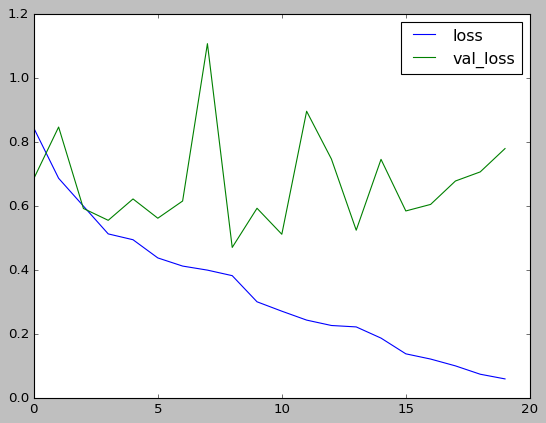

In [12]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

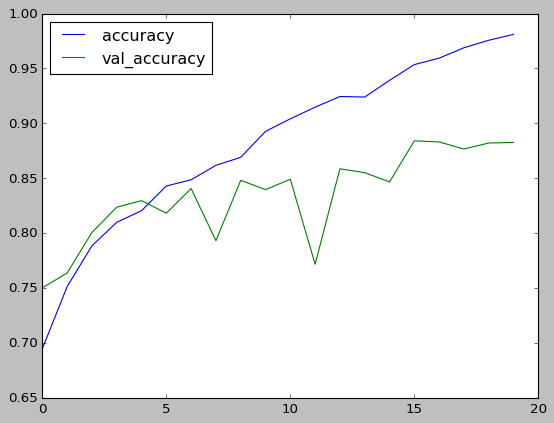

In [13]:
metrics[["accuracy","val_accuracy"]].plot()

In [14]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step


In [15]:
test_labels = test_image_gen.classes

In [16]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

Normalized confusion matrix
[[0.6        0.16923077 0.10769231 0.01538462 0.07692308 0.03076923
  0.        ]
 [0.00980392 0.85294118 0.04901961 0.         0.00980392 0.06862745
  0.00980392]
 [0.00913242 0.01369863 0.75342466 0.00456621 0.05479452 0.16438356
  0.        ]
 [0.04347826 0.04347826 0.         0.73913043 0.04347826 0.13043478
  0.        ]
 [0.01801802 0.01351351 0.09009009 0.         0.56756757 0.31081081
  0.        ]
 [0.         0.00298285 0.00671141 0.         0.01342282 0.97688292
  0.        ]
 [0.         0.         0.         0.         0.         0.07142857
  0.92857143]]


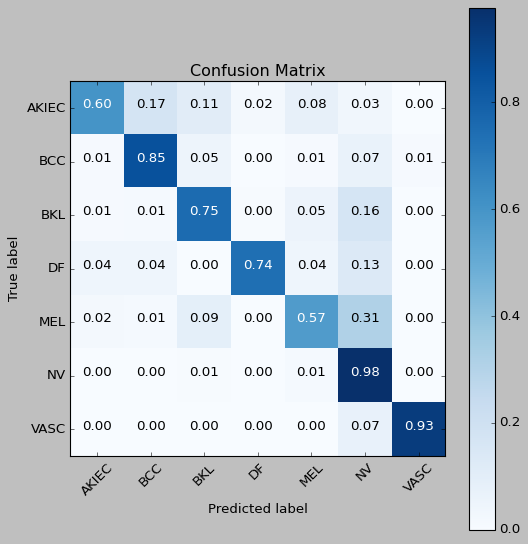

In [17]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [19]:
import disarray

# Instantiate the confusion matrix DataFrame with index and columns
#cm = confusion_matrix(a,b)
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

ModuleNotFoundError: No module named 'disarray'